In [1]:
import pandas as pd

# Load each CSV file
movies_df = pd.read_csv("movies_set1.csv")            # movies data
ratings_df = pd.read_csv("ratings_set1.csv")          # ratings data
links_df = pd.read_csv("links_set1.csv")            # links data
tags_df = pd.read_csv("tags_set1.csv")               # tags data

# Merge datasets on 'movieId' column
# Step-by-step merges to ensure data completeness and to handle potential mismatches
combined_df = pd.merge(movies_df, ratings_df, on='movieId', how='left')
combined_df = pd.merge(combined_df, links_df, on='movieId', how='left')
combined_df = pd.merge(combined_df, tags_df, on=['movieId', 'userId'], how='left')

# Display the resulting combined dataset
print(combined_df.head())


   movieId                   title                 genres    userId  rating  \
0   120510  Value for Money (1955)         Comedy|Romance       NaN     NaN   
1   212955     Face of Evil (1996)         Drama|Thriller       NaN     NaN   
2   193912      Spring 1941 (2007)      Drama|Romance|War       NaN     NaN   
3   163921       Wolf Creek (2016)  Crime|Horror|Thriller   75455.0     1.5   
4   163921       Wolf Creek (2016)  Crime|Horror|Thriller  160157.0     3.5   

    timestamp_x   imdbId    tmdbId  tag  timestamp_y  
0           NaN    48772  171394.0  NaN          NaN  
1           NaN   116264  268881.0  NaN          NaN  
2           NaN  1252616   53604.0  NaN          NaN  
3  1.601233e+09  4460878  388131.0  NaN          NaN  
4  1.609307e+09  4460878  388131.0  NaN          NaN  


In [2]:
movies_df.head()

,movieId,title,genres
0,120510,Value for Money (1955),Comedy|Romance
1,212955,Face of Evil (1996),Drama|Thriller
2,193912,Spring 1941 (2007),Drama|Romance|War
3,163921,Wolf Creek (2016),Crime|Horror|Thriller
4,126652,Raven the Little Rascal (2012),Animation|Children


In [ ]:
import pandas as pd
import requests


# Set up TMDb API access
api_key = "56376c7845f4c1abd6553e5925f30584"  # Replace with your actual TMDb API key
base_url = "https://api.themoviedb.org/3/movie/"

# Function to fetch top actors for a movie
def get_top_actors(imdb_id):
    url = f"{base_url}{imdb_id}/credits?api_key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        # Extract the top actors, let's say the first 5 in billing order
        top_actors = [member['name'] for member in data['cast'][:10]]
        return top_actors
    else:
        return []

# Iterate through the movies and fetch actors
movie_actors = []

for _, row in movies_df.iterrows():
    movie_id = row['movieId']
    imdb_id = row['title']  # or row['title'] if imdbId is unavailable and need title-based search
    top_actors = get_top_actors(imdb_id)
    for rank, actor in enumerate(top_actors, start=1):
        movie_actors.append({'movieId': movie_id, 'title': row['title'], 'actor': actor, 'actor_rank': rank})

# Convert to DataFrame and save as CSV
movie_actors_df = pd.DataFrame(movie_actors)
movie_actors_df.to_csv("movie_actors.csv", index=False)
print("Movie-actor relationships saved to movie_actors.csv")


Movie-actor relationships saved to movie_actors.csv


In [3]:
from bs4 import BeautifulSoup
import requests

def scrape_top_actors(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    # Find and extract actors based on HTML structure
    # Example:
    actors = soup.select("div.actor-name")[:20]  # Modify selector based on the actual structure
    return [actor.text.strip() for actor in actors]


In [4]:
# Load data (assuming movie_actors.csv was created from the previous task)
user_movie_ratings = pd.read_csv("ratings_set1.csv")
movie_actor_df = pd.read_csv("movie_actors.csv")

# Merge user ratings with actors
user_actor_ratings = user_movie_ratings.merge(movie_actor_df, on="movieId", how="inner")

# Calculate average rating per actor for each user
user_actor_ratings = user_actor_ratings.groupby(['userId', 'actor']).agg({'rating': 'mean'}).reset_index()
user_actor_ratings.rename(columns={'rating': 'user_actor_rating'}, inplace=True)

# Step 3: Normalize or preprocess the data
# Example: Filter out low-activity users or actors with few ratings
user_counts = user_actor_ratings['userId'].value_counts()
actor_counts = user_actor_ratings['actor'].value_counts()

# Keep users who have rated at least `min_user_ratings` actors and actors with at least `min_actor_ratings` ratings
min_user_ratings = 5
min_actor_ratings = 5

filtered_user_actor_ratings = user_actor_ratings[
    (user_actor_ratings['userId'].isin(user_counts[user_counts >= min_user_ratings].index)) &
    (user_actor_ratings['actor'].isin(actor_counts[actor_counts >= min_actor_ratings].index))
]

# Step 4: Save the user-actor ratings dataset for future use
filtered_user_actor_ratings.to_csv("user_actor_ratings.csv", index=False)


In [5]:
!pip install surprise

In [6]:
print(user_actor_ratings[:50])

    userId               actor  user_actor_rating
0      106       Albert Brooks                5.0
1      106     Alexander Gould                5.0
2      106     Ellen DeGeneres                5.0
3      106       Geoffrey Rush                5.0
4      106        Willem Dafoe                5.0
5      184         Albert Hall                4.0
6      184    Frederic Forrest                4.0
7      184  Laurence Fishburne                4.0
8      184        Martin Sheen                4.0
9      184         Sam Bottoms                4.0
10     239  Alexandru Potocean                2.0
11     239      Amanda Plummer                2.5
12     239    Anamaria Marinca                2.0
13     239       Kanako Masuda                1.5
14     239       Laura Vasiliu                2.0
15     239      Leonor Watling                2.5
16     239  Luminița Gheorghiu                2.0
17     239         Machiko Ono                1.5
18     239     Makiko Watanabe                1.5


In [7]:
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD, accuracy

from surprise.model_selection import train_test_split  # Import train_test_split from surprise

# Load data into Surprise format
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(filtered_user_actor_ratings[['userId', 'actor', 'user_actor_rating']], reader)

# Split data into train and test sets in the way that Surprise expects
trainset, testset = train_test_split(data, test_size=0.2)


# Train the SVD algorithm
algo = SVD(n_factors=100, n_epochs=30, lr_all=0.005, reg_all=0.02)
algo.fit(trainset)

# Function to recommend top actors for a user
def get_top_actors_for_user(user_id, n=20):
    unique_actors = user_actor_ratings['actor'].unique()
    predictions = [algo.predict(user_id, actor) for actor in unique_actors]
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    return [pred.iid for pred in top_predictions]

# Example: Get top actors for a specific user
top_actors_for_user_1 = get_top_actors_for_user(user_id=1)
print("Top actors recommended for User 1:", top_actors_for_user_1)


Top actors recommended for User 1: ['Marisa Paredes', 'Penélope Cruz', 'Antonia San Juan', 'Nancy Cartwright', 'Sophie Quinton', 'Candela Peña', 'Catherine Jacob', 'Michèle Moretti', 'Hank Azaria', 'Yasmine Belmadi', 'Laurent Lucas', 'Cecilia Roth', 'Chip Fitzwater', 'Bruce Brown', 'Alexander Gould', 'Dan Castellaneta', 'Ellen DeGeneres', 'Geoffrey Rush', 'Albert Brooks', 'Willem Dafoe']


In [8]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD, accuracy

# Load datasets
movies = pd.read_csv("movies_set1.csv")
ratings = pd.read_csv("ratings_set1.csv")
movie_actors = pd.read_csv("movie_actors.csv")

# Step 1: Map Users to Genres via Movies
# Merge ratings with movies to get genres
user_genre_ratings = ratings.merge(movies, on="movieId", how="inner")

# Explode genres into separate rows
user_genre_ratings['genres'] = user_genre_ratings['genres'].str.split('|')
user_genre_ratings = user_genre_ratings.explode('genres')

# Calculate average rating per genre for each user
user_genre_pref = user_genre_ratings.groupby(['userId', 'genres']).agg({'rating': 'mean'}).reset_index()
user_genre_pref.rename(columns={'rating': 'user_genre_rating'}, inplace=True)

# Step 2: Link Movies to Genres and Actors
# Merge movie_actors with movies to get genre information
movie_genre_actors = movies.merge(movie_actors, on="movieId", how="inner")
movie_genre_actors['genres'] = movie_genre_actors['genres'].str.split('|')
movie_genre_actors = movie_genre_actors.explode('genres')

# Step 3: Find Top Actors for Each Genre
# Group by genre and actor, and calculate popularity (e.g., count of movies or average rating)
top_actors_per_genre = movie_genre_actors.groupby(['genres', 'actor']).size().reset_index(name='actor_popularity')
top_actors_per_genre = top_actors_per_genre.sort_values(['genres', 'actor_popularity'], ascending=[True, False])

# Step 4: Recommend Actors Based on User Preferences
def get_top_actors_for_user(user_id, n=10):
    # Get user's preferred genres
    user_top_genres = user_genre_pref[user_genre_pref['userId'] == user_id]
    user_top_genres = user_top_genres.sort_values('user_genre_rating', ascending=False)['genres'].tolist()

    # Get top actors for user's preferred genres
    recommended_actors = []
    for genre in user_top_genres:
        genre_top_actors = top_actors_per_genre[top_actors_per_genre['genres'] == genre]['actor'].tolist()
        recommended_actors.extend(genre_top_actors[:n])

    # Deduplicate and return top N actors
    return list(dict.fromkeys(recommended_actors))[:n]

# Example: Get top actors for User 1
top_actors_for_user_1 = get_top_actors_for_user(user_id=1, n=20)
print("Top actors recommended for User 1:", top_actors_for_user_1)


Top actors recommended for User 1: []


In [9]:
# Define evaluation functions
def precision_at_k(predictions, k=20):
    top_k_preds = [pred for pred in predictions if pred.est >= 4][:k]
    relevant_items = sum([1 for pred in top_k_preds if pred.r_ui >= 4])
    return relevant_items / k if k > 0 else 0

def recall_at_k(predictions, k=20):
    top_k_preds = [pred for pred in predictions if pred.est >= 4][:k]
    relevant_items = sum([1 for pred in top_k_preds if pred.r_ui >= 4])
    return relevant_items / len(predictions) if len(predictions) > 0 else 0

# Calculate precision and recall on the test set
test_predictions = algo.test(testset)
precision = precision_at_k(test_predictions, k=20)
recall = recall_at_k(test_predictions, k=20)

print(f'Precision@5: {precision}')
print(f'Recall@5: {recall}')


Precision@5: 1.0
Recall@5: 0.008061265618702136


In [10]:
import numpy as np

# Define NDCG@k function
def ndcg_at_k(predictions, k=20):
    # Sort predictions by estimated rating in descending order
    sorted_preds = sorted(predictions, key=lambda x: x.est, reverse=True)[:k]

    # Calculate DCG
    dcg = sum([(2 ** pred.r_ui - 1) / np.log2(idx + 2) for idx, pred in enumerate(sorted_preds)])

    # Calculate IDCG (Ideal DCG)
    sorted_by_relevance = sorted(predictions, key=lambda x: x.r_ui, reverse=True)[:k]
    idcg = sum([(2 ** pred.r_ui - 1) / np.log2(idx + 2) for idx, pred in enumerate(sorted_by_relevance)])

    # Return NDCG
    return dcg / idcg if idcg > 0 else 0

# Calculate NDCG on the test set
ndcg = ndcg_at_k(test_predictions, k=20)

print(f'NDCG@20: {ndcg}')


NDCG@20: 1.0


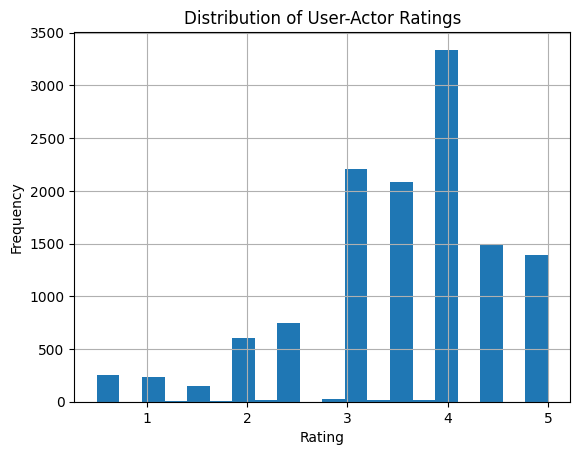

Top-rated actors for User 1: []


In [11]:
import matplotlib.pyplot as plt

# Plot distribution of user-actor ratings
user_actor_ratings['user_actor_rating'].hist(bins=20)
plt.title("Distribution of User-Actor Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Visualize top-rated actors for a sample user
sample_user_id = 1
sample_top_actors = get_top_actors_for_user(sample_user_id, n=5)
print(f"Top-rated actors for User {sample_user_id}: {sample_top_actors}")
